In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/diabetes.csv')


In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:

df.describe()  # Summary statistics for numerical columns
df.info()      # Data types and missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


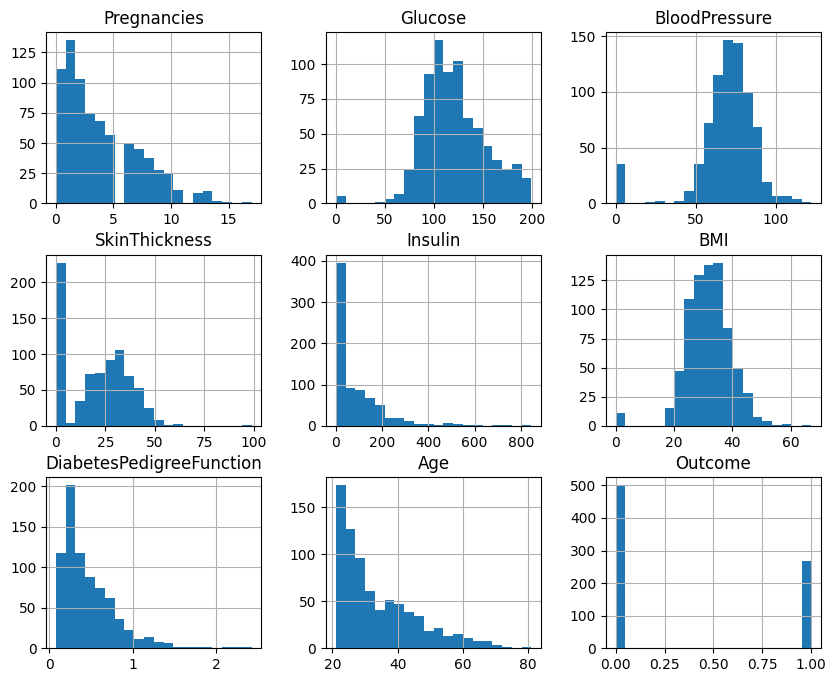

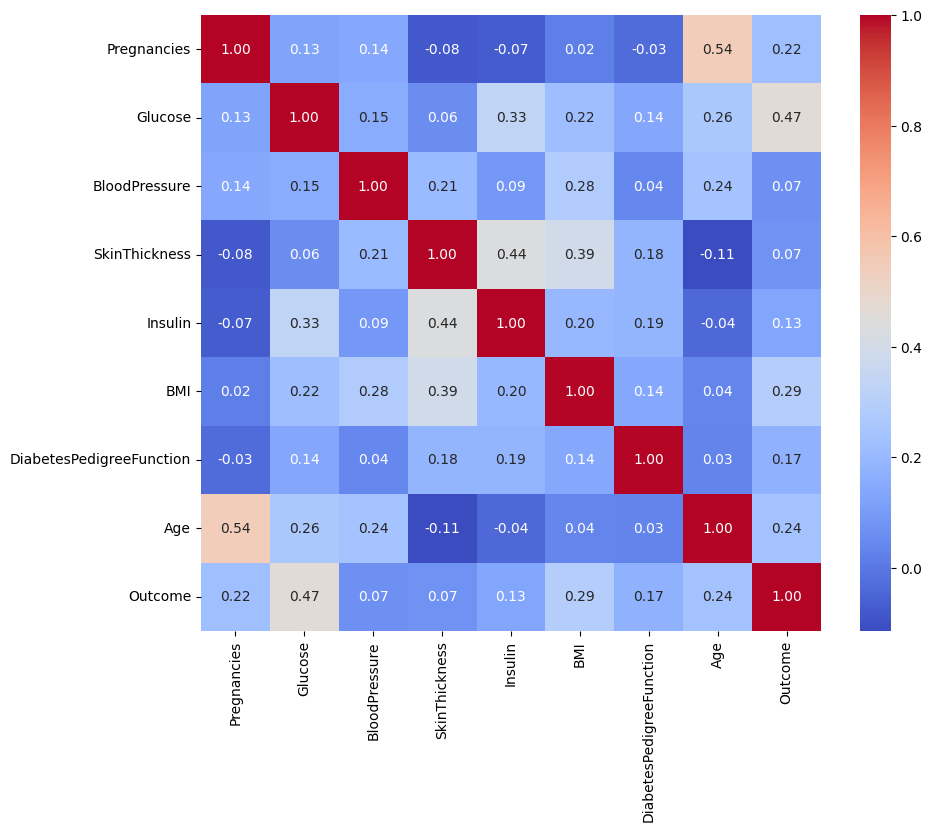

In [5]:
# Distribution of numerical variables
df.hist(bins=20, figsize=(10, 8))
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


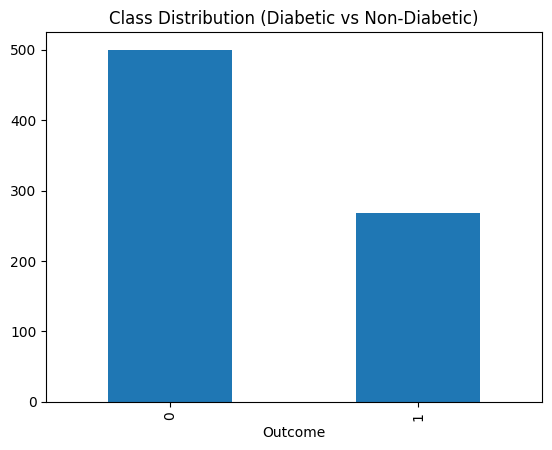

In [6]:
# Since this is a classification task (diabetic vs non-diabetic), it’s useful to check the distribution of the target variable (Outcome).
df['Outcome'].value_counts().plot(kind='bar')
plt.title('Class Distribution (Diabetic vs Non-Diabetic)')
plt.show()


In [7]:
df.isnull().sum() # handle missing value
df.fillna(df.mean(), inplace=True)  #  filling with mean

# remove outliers
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include=np.number))
df_clean = df[(np.abs(z_scores) < 3).all(axis=1)]  # Remove outliers (Z-score > 3)



In [8]:
## split data
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Outcome'])  # Features
y = df['Outcome']                # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
## train with decison tree model
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [10]:
## cross-validation to optimize hyperparamter
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
model = grid_search.best_estimator_


Best Parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [11]:
## evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.76
Precision: 0.68
Recall: 0.62
F1 Score: 0.65


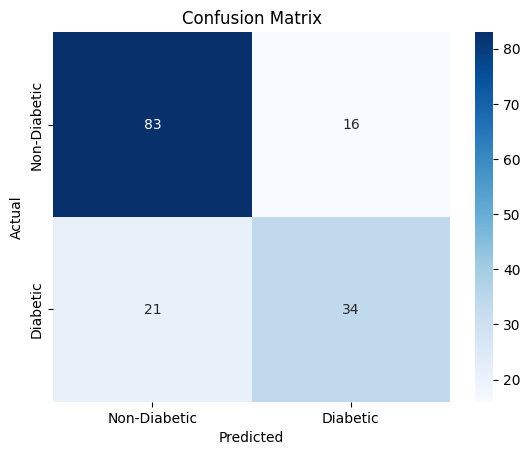

In [12]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


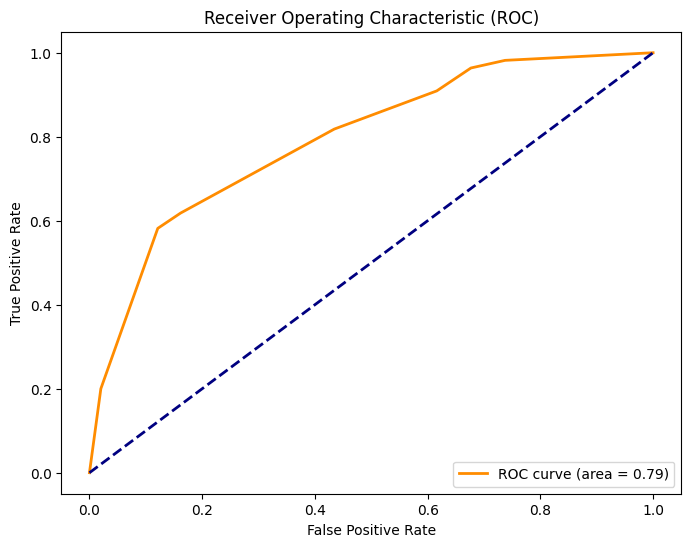

In [13]:
# ROC Curve and calculate the AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


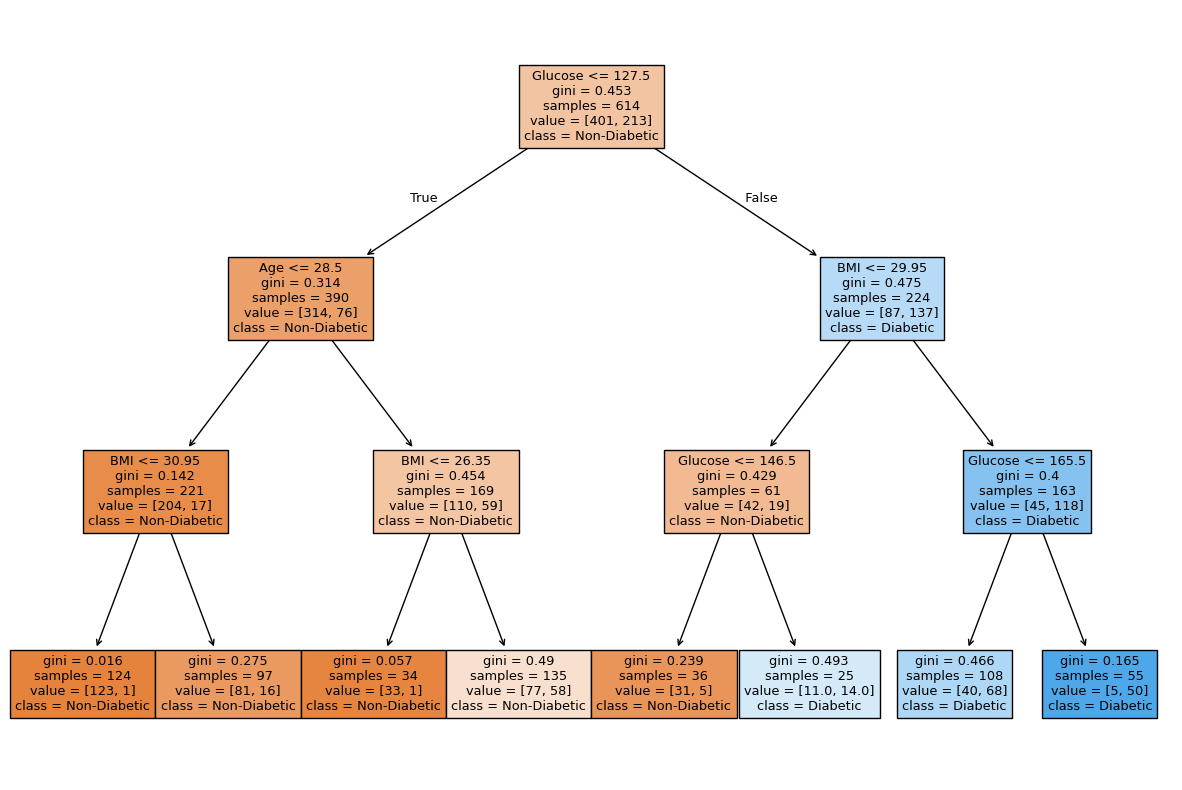

In [14]:
# visualize the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=X.columns, class_names=['Non-Diabetic', 'Diabetic'], filled=True)
plt.show()


In [15]:
# Identify important features
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                    Feature  Importance
1                   Glucose    0.597370
5                       BMI    0.262156
7                       Age    0.140474
0               Pregnancies    0.000000
3             SkinThickness    0.000000
2             BloodPressure    0.000000
4                   Insulin    0.000000
6  DiabetesPedigreeFunction    0.000000


In [16]:
# Introduce noise in features and see how the model performs
X_noisy = X_test.copy()
X_noisy['Glucose'] += np.random.normal(0, 10, size=X_noisy.shape[0])  # Add noise to the 'Glucose' feature
y_pred_noisy = model.predict(X_noisy)
